Sorry! This code is not particularly cleaned up...but we thought it would be good to share for context on our data wrangling process.

In [68]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from datasets import Dataset, load_from_disk, load_dataset, concatenate_datasets

In [22]:
all_dfs = ['combined_49.pkl', 'combined_99.pkl', 'combined_149.pkl', 'combined_199.pkl', 'combined_249.pkl', 'combined_299.pkl', 'combined_331.pkl']
new_dfs = []
for i in tqdm(range(len(all_dfs))):
    pickled_df = all_dfs[i]
    file_path = os.path.join('basicdata/comb/', pickled_df)
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    # drop the transaction index column
    df = df.drop(columns=['transaction_index'])
    # create a columns that is receipt_effective_gas_price divided by 1e9 and as float32
    df['receipt_effective_gas_price_gwei'] = (df['receipt_effective_gas_price'] / 1e9).astype('float32')
    # drop the original receipt_effective_gas_price column
    df = df.drop(columns=['receipt_effective_gas_price'])
    # create new columns for mean, median, standard deviation, min, and max of receipt_effective_gas_price_gwei grouped by block_timestamp
    df = df.groupby('block_timestamp').agg({'receipt_effective_gas_price_gwei': ['mean', 'median', 'min', 'max', 'std']})
    # flatten the columns
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    # reset the index
    df = df.reset_index()
    new_dfs.append(df)



100%|██████████| 7/7 [06:34<00:00, 56.39s/it]


In [23]:
combined_df = pd.concat(new_dfs, ignore_index=True)
combined_df = combined_df.sort_values(by='block_timestamp')
combined_df

,block_timestamp,receipt_effective_gas_price_gwei_mean,receipt_effective_gas_price_gwei_median,receipt_effective_gas_price_gwei_min,receipt_effective_gas_price_gwei_max,receipt_effective_gas_price_gwei_std
0,2017-01-01 00:00:31 UTC,22.857143,20.000000,20.000000,40.000000,7.559289
1,2017-01-01 00:00:42 UTC,30.000000,30.000000,30.000000,30.000000,NaN
2,2017-01-01 00:00:52 UTC,20.000000,20.000000,20.000000,20.000000,0.000000
3,2017-01-01 00:01:30 UTC,20.000000,20.000000,20.000000,20.000000,0.000000
4,2017-01-01 00:02:24 UTC,20.000000,20.000000,20.000000,20.000000,0.000000
...,...,...,...,...,...,...
16184710,2024-04-11 03:21:11 UTC,13.487906,12.457315,12.450240,54.000000,3.488668
16184711,2024-04-11 03:21:23 UTC,15.408032,14.096536,13.996535,96.012955,7.530531
16184712,2024-04-11 03:21:35 UTC,14.873260,13.643182,13.460486,38.460487,3.114672
16184713,2024-04-11 03:21:47 UTC,24.692823,15.000000,13.187118,1001.187134,79.731486


In [26]:
dataset = Dataset.from_pandas(combined_df)
dataset.save_to_disk('blockwise_dataset')
dataset = load_from_disk('blockwise_dataset')
print(dataset)

Saving the dataset (0/2 shards):   0%|          | 0/16184715 [00:00<?, ? examples/s]

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std'],
    num_rows: 16184715
})


In [31]:
dataset = dataset.map(lambda x: {'receipt_effective_gas_price_gwei_std': 0 if x['receipt_effective_gas_price_gwei_min'] == x['receipt_effective_gas_price_gwei_max'] else x['receipt_effective_gas_price_gwei_std']}, num_proc=32)
print(dataset)

Map (num_proc=32):   0%|          | 0/16184715 [00:00<?, ? examples/s]

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std'],
    num_rows: 16184715
})


In [32]:
dataset_new = dataset.map(lambda x: {'receipt_effective_gas_price_gwei_mean': np.round(x['receipt_effective_gas_price_gwei_mean'], 3), 'receipt_effective_gas_price_gwei_median': np.round(x['receipt_effective_gas_price_gwei_median'], 3), 'receipt_effective_gas_price_gwei_min': np.round(x['receipt_effective_gas_price_gwei_min'], 3), 'receipt_effective_gas_price_gwei_max': np.round(x['receipt_effective_gas_price_gwei_max'], 3), 'receipt_effective_gas_price_gwei_std': np.round(x['receipt_effective_gas_price_gwei_std'], 3)}, num_proc=32)
dataset_new.save_to_disk('blockwise_dataset_new')

Map (num_proc=32):   0%|          | 0/16184715 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/16184715 [00:00<?, ? examples/s]

In [33]:
dataset = load_from_disk('blockwise_dataset_new')
print(dataset)
print(dataset[0])

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std'],
    num_rows: 16184715
})
{'block_timestamp': '2017-01-01 00:00:31 UTC', 'receipt_effective_gas_price_gwei_mean': 22.85700035095215, 'receipt_effective_gas_price_gwei_median': 20.0, 'receipt_effective_gas_price_gwei_min': 20.0, 'receipt_effective_gas_price_gwei_max': 40.0, 'receipt_effective_gas_price_gwei_std': 7.559}


In [34]:
df = dataset.data.to_pandas()
df

,block_timestamp,receipt_effective_gas_price_gwei_mean,receipt_effective_gas_price_gwei_median,receipt_effective_gas_price_gwei_min,receipt_effective_gas_price_gwei_max,receipt_effective_gas_price_gwei_std
0,2017-01-01 00:00:31 UTC,22.857000,20.000,20.000,40.000000,7.559
1,2017-01-01 00:00:42 UTC,30.000000,30.000,30.000,30.000000,0.000
2,2017-01-01 00:00:52 UTC,20.000000,20.000,20.000,20.000000,0.000
3,2017-01-01 00:01:30 UTC,20.000000,20.000,20.000,20.000000,0.000
4,2017-01-01 00:02:24 UTC,20.000000,20.000,20.000,20.000000,0.000
...,...,...,...,...,...,...
16184710,2024-04-11 03:21:11 UTC,13.488000,12.457,12.450,54.000000,3.489
16184711,2024-04-11 03:21:23 UTC,15.408000,14.097,13.997,96.013000,7.531
16184712,2024-04-11 03:21:35 UTC,14.873000,13.643,13.460,38.459999,3.115
16184713,2024-04-11 03:21:47 UTC,24.693001,15.000,13.187,1001.187012,79.731


In [20]:
df
# show the rows which have NaN values
df[df.isna().any(axis=1)]

,block_timestamp,receipt_effective_gas_price_gwei_mean,receipt_effective_gas_price_gwei_median,receipt_effective_gas_price_gwei_min,receipt_effective_gas_price_gwei_max,receipt_effective_gas_price_gwei_std
1,2017-01-01 00:00:42 UTC,30.0,30.0,30.0,30.0,NaN
11,2017-01-01 00:05:32 UTC,20.0,20.0,20.0,20.0,NaN
26,2017-01-01 00:09:12 UTC,20.0,20.0,20.0,20.0,NaN
29,2017-01-01 00:09:36 UTC,20.0,20.0,20.0,20.0,NaN
30,2017-01-01 00:09:55 UTC,40.0,40.0,40.0,40.0,NaN
...,...,...,...,...,...,...
3774419,2019-01-02 19:18:23 UTC,51.0,51.0,51.0,51.0,NaN
3774584,2019-01-02 20:01:54 UTC,41.0,41.0,41.0,41.0,NaN
3774683,2019-01-02 20:24:02 UTC,20.0,20.0,20.0,20.0,NaN
3774728,2019-01-02 20:35:37 UTC,20.0,20.0,20.0,20.0,NaN


In [60]:
dataset_main = load_from_disk("blockwise_dataset_new")
dataset_block = load_from_disk("dataset_blockmetadata")
print(dataset_main)
print(dataset_block)


Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std'],
    num_rows: 16184715
})
Dataset({
    features: ['timestamp', 'size', 'gas_limit', 'gas_used', 'transaction_count', 'base_fee_per_gas'],
    num_rows: 16722403
})


In [61]:
dataset_main = dataset_main.sort('block_timestamp')
dataset_block = dataset_block.sort('timestamp')

In [62]:
dataset_block = dataset_block.filter(lambda x: x['transaction_count'] > 0, num_proc=32)
print(dataset_block)

Filter (num_proc=32):   0%|          | 0/16722403 [00:00<?, ? examples/s]

Dataset({
    features: ['timestamp', 'size', 'gas_limit', 'gas_used', 'transaction_count', 'base_fee_per_gas'],
    num_rows: 16189848
})


In [63]:
print(dataset_main)
print(dataset_block)

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std'],
    num_rows: 16184715
})
Dataset({
    features: ['timestamp', 'size', 'gas_limit', 'gas_used', 'transaction_count', 'base_fee_per_gas'],
    num_rows: 16189848
})


In [65]:
print(dataset_main[len(dataset_main) - 1])
print(dataset_block[len(dataset_main) - 1])

{'block_timestamp': '2024-04-11 03:21:59 UTC', 'receipt_effective_gas_price_gwei_mean': 15.024999618530273, 'receipt_effective_gas_price_gwei_median': 12.998000144958496, 'receipt_effective_gas_price_gwei_min': 12.991000175476074, 'receipt_effective_gas_price_gwei_max': 133.1540069580078, 'receipt_effective_gas_price_gwei_std': 9.358}
{'timestamp': '2024-04-11 03:21:59 UTC', 'size': 201831, 'gas_limit': 30000000, 'gas_used': 26649427, 'transaction_count': 254, 'base_fee_per_gas': 12991374093}


In [66]:
dataset_block = dataset_block.select(range(len(dataset_main)))
print(dataset_block)

Dataset({
    features: ['timestamp', 'size', 'gas_limit', 'gas_used', 'transaction_count', 'base_fee_per_gas'],
    num_rows: 16184715
})


In [73]:
dataset_main = dataset_main.add_column('block_size', dataset_block['size'])
dataset_main = dataset_main.add_column('block_gas_limit', dataset_block['gas_limit'])
dataset_main = dataset_main.add_column('block_gas_used', dataset_block['gas_used'])
dataset_main = dataset_main.add_column('block_transaction_count', dataset_block['transaction_count'])
dataset_main = dataset_main.add_column('block_base_fee_per_gas', dataset_block['base_fee_per_gas'])
print(dataset_main)

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std', 'block_size', 'block_gas_limit', 'block_gas_used', 'block_transaction_count', 'block_base_fee_per_gas'],
    num_rows: 16184715
})


In [74]:
dataset_main.save_to_disk('final_dataset_v1')
dataset_main = load_from_disk('final_dataset_v1')
print(dataset_main)


Saving the dataset (0/3 shards):   0%|          | 0/16184715 [00:00<?, ? examples/s]

Dataset({
    features: ['block_timestamp', 'receipt_effective_gas_price_gwei_mean', 'receipt_effective_gas_price_gwei_median', 'receipt_effective_gas_price_gwei_min', 'receipt_effective_gas_price_gwei_max', 'receipt_effective_gas_price_gwei_std', 'block_size', 'block_gas_limit', 'block_gas_used', 'block_transaction_count', 'block_base_fee_per_gas'],
    num_rows: 16184715
})


In [75]:
dataset_main = dataset_main.rename_columns({'block_timestamp': 'timestamp', "receipt_effective_gas_price_gwei_mean": "avg_gas_price_gwei", "receipt_effective_gas_price_gwei_median": "med_gas_price_gwei", "receipt_effective_gas_price_gwei_min": "min_gas_price_gwei", "receipt_effective_gas_price_gwei_max": "max_gas_price_gwei", "receipt_effective_gas_price_gwei_std": "std_gas_price_gwei"})
print(dataset_main)

Dataset({
    features: ['timestamp', 'avg_gas_price_gwei', 'med_gas_price_gwei', 'min_gas_price_gwei', 'max_gas_price_gwei', 'std_gas_price_gwei', 'block_size', 'block_gas_limit', 'block_gas_used', 'block_transaction_count', 'block_base_fee_per_gas'],
    num_rows: 16184715
})


In [80]:
import pickle

price_data_df = pd.read_pickle('/scratch/gpfs/DANQIC/aatmikg/llm-offensive-humor/473/merged_bella_data/merged_data_2_with_interpolation.pkl') 
price_data = Dataset.from_pandas(price_data_df)
print(price_data)

Dataset({
    features: ['timestamp_minute', 'Open', 'High', 'Low', 'Close', 'Volume', 'block_number', 'value', 'gas', 'gas_price', 'receipt_cumulative_gas_used', 'receipt_gas_used', 'receipt_effective_gas_price', 'Openb', 'Highb', 'Lowb', 'Closeb', 'Volumeb'],
    num_rows: 3911908
})


In [81]:
print(price_data[0])

{'timestamp_minute': Timestamp('2016-03-11 05:53:00'), 'Open': 11.85, 'High': 11.85, 'Low': 11.85, 'Close': 11.85, 'Volume': 0.024, 'block_number': None, 'value': None, 'gas': None, 'gas_price': None, 'receipt_cumulative_gas_used': None, 'receipt_gas_used': None, 'receipt_effective_gas_price': None, 'Openb': 422.6, 'Highb': 422.6, 'Lowb': 422.08, 'Closeb': 422.08, 'Volumeb': 26.95}


In [78]:
print(dataset_main[-1000]["block_gas_used"])

9496465


In [85]:
import datetime

In [88]:
# drop all columns except for "Open", "Volume, "Openb", "Volumeb"
price_data_df = price_data_df[["timestamp_minute", "Open", "Volume", "Openb", "Volumeb"]]
price_data_df
# drop rows witj timestamp_minute before 2017
price_data_df = price_data_df[price_data_df["timestamp_minute"] >= datetime.datetime(2017, 1, 1)]
price_data_df

,timestamp_minute,Open,Volume,Openb,Volumeb
110373,2017-01-01 00:00:00,8.42,205.780000,973.37,3.772000
110374,2017-01-01 00:01:00,8.15,31.484000,966.62,9.272000
110375,2017-01-01 00:02:00,8.11,100.000000,967.05,18.580000
110376,2017-01-01 00:04:00,8.11,210.249000,973.40,5.509000
110377,2017-01-01 00:05:00,8.11,100.000000,973.35,14.948000
...,...,...,...,...,...
3911903,2024-04-09 19:54:00,3503.89,12.509132,69163.44,6.419044
3911904,2024-04-09 19:55:00,3504.19,38.420469,69142.53,10.057225
3911905,2024-04-09 19:56:00,3505.20,12.027140,69136.61,3.841438
3911906,2024-04-09 19:57:00,3506.34,13.175786,69143.50,4.058412


In [89]:
price_data_df['timestamp_minute'] = pd.to_datetime(price_data_df['timestamp_minute'])

# Setting the datetime column as the index
price_data_df.set_index('timestamp_minute', inplace=True)

# Resample to second-level granularity and interpolate
price_data_df_resampled = price_data_df.resample('S').interpolate(method='linear')

# Show the first few rows of the resampled DataFrame


/tmp/ipykernel_4170782/3622049583.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  price_data_df_resampled = price_data_df.resample('S').interpolate(method='linear')


                     Open   Volume   Openb  Volumeb
timestamp_minute                                   
2017-01-01 00:00:00  8.42  205.780  973.37    3.772
2017-01-01 00:01:00  8.15   31.484  966.62    9.272
2017-01-01 00:02:00  8.11  100.000  967.05   18.580
2017-01-01 00:04:00  8.11  210.249  973.40    5.509
2017-01-01 00:05:00  8.11  100.000  973.35   14.948


In [ ]:
# left join the two datasets on the timestamp column


In [103]:
# print type of the timestamp column
dataset_main_df = dataset_main.data.to_pandas()
dataset_main_df['timestamp'] = pd.to_datetime(dataset_main_df['timestamp'])

In [105]:
dataset_main_df.tz_localize(None)

,avg_gas_price_gwei,med_gas_price_gwei,min_gas_price_gwei,max_gas_price_gwei,std_gas_price_gwei,block_size,block_gas_limit,block_gas_used,block_transaction_count,block_base_fee_per_gas
timestamp,,,,,,,,,,
2017-01-01 00:00:31,22.857000,20.000,20.000,40.000000,7.559,1424,4008454,217724,7,NaN
2017-01-01 00:00:42,30.000000,30.000,30.000,30.000000,0.000,644,4004541,21000,1,NaN
2017-01-01 00:00:52,20.000000,20.000,20.000,20.000000,0.000,1787,4008450,313198,10,NaN
2017-01-01 00:01:30,20.000000,20.000,20.000,20.000000,0.000,1719,4000625,224241,10,NaN
2017-01-01 00:02:24,20.000000,20.000,20.000,20.000000,0.000,1239,4000000,174754,6,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-04-11 03:21:11,13.488000,12.457,12.450,54.000000,3.489,128846,30000000,29903767,272,1.245024e+10
2024-04-11 03:21:23,15.408000,14.097,13.997,96.013000,7.531,44763,30000000,10404158,119,1.399654e+10
2024-04-11 03:21:35,14.873000,13.643,13.460,38.459999,3.115,77627,30000000,12562921,118,1.346049e+10


In [113]:
dataset_main_df = dataset_main_df.tz_localize(None)
dataset_main_df

,avg_gas_price_gwei,med_gas_price_gwei,min_gas_price_gwei,max_gas_price_gwei,std_gas_price_gwei,block_size,block_gas_limit,block_gas_used,block_transaction_count,block_base_fee_per_gas
timestamp,,,,,,,,,,
2017-01-01 00:00:31,22.857000,20.000,20.000,40.000000,7.559,1424,4008454,217724,7,NaN
2017-01-01 00:00:42,30.000000,30.000,30.000,30.000000,0.000,644,4004541,21000,1,NaN
2017-01-01 00:00:52,20.000000,20.000,20.000,20.000000,0.000,1787,4008450,313198,10,NaN
2017-01-01 00:01:30,20.000000,20.000,20.000,20.000000,0.000,1719,4000625,224241,10,NaN
2017-01-01 00:02:24,20.000000,20.000,20.000,20.000000,0.000,1239,4000000,174754,6,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-04-11 03:21:11,13.488000,12.457,12.450,54.000000,3.489,128846,30000000,29903767,272,1.245024e+10
2024-04-11 03:21:23,15.408000,14.097,13.997,96.013000,7.531,44763,30000000,10404158,119,1.399654e+10
2024-04-11 03:21:35,14.873000,13.643,13.460,38.459999,3.115,77627,30000000,12562921,118,1.346049e+10


In [114]:
# left join the two datasets on the timestamp column
merged_df = dataset_main_df.join(price_data_df_resampled, how='left')
merged_df = merged_df.reset_index()
merged_df = merged_df.rename(columns={"index": "timestamp"})
merged_df

,timestamp,avg_gas_price_gwei,med_gas_price_gwei,min_gas_price_gwei,max_gas_price_gwei,std_gas_price_gwei,block_size,block_gas_limit,block_gas_used,block_transaction_count,block_base_fee_per_gas,Open,Volume,Openb,Volumeb
0,2017-01-01 00:00:31,22.857000,20.000,20.000,40.000000,7.559,1424,4008454,217724,7,NaN,8.2805,115.727067,969.8825,6.613667
1,2017-01-01 00:00:42,30.000000,30.000,30.000,30.000000,0.000,644,4004541,21000,1,NaN,8.2310,83.772800,968.6450,7.622000
2,2017-01-01 00:00:52,20.000000,20.000,20.000,20.000000,0.000,1787,4008450,313198,10,NaN,8.1860,54.723467,967.5200,8.538667
3,2017-01-01 00:01:30,20.000000,20.000,20.000,20.000000,0.000,1719,4000625,224241,10,NaN,8.1300,65.742000,966.8350,13.926000
4,2017-01-01 00:02:24,20.000000,20.000,20.000,20.000000,0.000,1239,4000000,174754,6,NaN,8.1100,122.049800,968.3200,15.965800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16184710,2024-04-11 03:21:11,13.488000,12.457,12.450,54.000000,3.489,128846,30000000,29903767,272,1.245024e+10,NaN,NaN,NaN,NaN
16184711,2024-04-11 03:21:23,15.408000,14.097,13.997,96.013000,7.531,44763,30000000,10404158,119,1.399654e+10,NaN,NaN,NaN,NaN
16184712,2024-04-11 03:21:35,14.873000,13.643,13.460,38.459999,3.115,77627,30000000,12562921,118,1.346049e+10,NaN,NaN,NaN,NaN
16184713,2024-04-11 03:21:47,24.693001,15.000,13.187,1001.187012,79.731,64639,30000000,13218775,165,1.318712e+10,NaN,NaN,NaN,NaN


In [115]:
dataset_final_v2 = Dataset.from_pandas(merged_df)
dataset_final_v2.save_to_disk('final_dataset_v2')

Saving the dataset (0/4 shards):   0%|          | 0/16184715 [00:00<?, ? examples/s]

In [145]:
print(dataset_final_v2[-9358])

{'timestamp': Timestamp('2024-04-09 19:58:11'), 'avg_gas_price_gwei': 24.76799964904785, 'med_gas_price_gwei': 24.274999618530273, 'min_gas_price_gwei': 22.274999618530273, 'max_gas_price_gwei': 151.6280059814453, 'std_gas_price_gwei': 8.255, 'block_size': 85031, 'block_gas_limit': 30000000, 'block_gas_used': 17159199, 'block_transaction_count': 262, 'block_base_fee_per_gas': 22274867478.0, 'Open': None, 'Volume': None, 'Openb': None, 'Volumeb': None}


In [155]:
dataset_final_v3 = dataset_final_v2.select(range(len(dataset_final_v2) - 9357))

In [156]:
print(dataset_final_v3[-1])

{'timestamp': Timestamp('2024-04-09 19:57:59'), 'avg_gas_price_gwei': 24.44099998474121, 'med_gas_price_gwei': 23.211999893188477, 'min_gas_price_gwei': 23.131999969482422, 'max_gas_price_gwei': 40.303001403808594, 'std_gas_price_gwei': 2.639, 'block_size': 130932, 'block_gas_limit': 30000000, 'block_gas_used': 10552224, 'block_transaction_count': 113, 'block_base_fee_per_gas': 23132260071.0, 'Open': 3505.3173333333334, 'Volume': 20.3073377205, 'Openb': 69137.128, 'Volumeb': 1.6218242163333336}


In [160]:
df = dataset_final_v3.data.to_pandas()
df

,timestamp,avg_gas_price_gwei,med_gas_price_gwei,min_gas_price_gwei,max_gas_price_gwei,std_gas_price_gwei,block_size,block_gas_limit,block_gas_used,block_transaction_count,block_base_fee_per_gas,Open,Volume,Openb,Volumeb
0,2017-01-01 00:00:31,22.857000,20.000000,20.000000,40.000000,7.559,1424,4008454,217724,7,NaN,8.280500,115.727067,969.8825,6.613667
1,2017-01-01 00:00:42,30.000000,30.000000,30.000000,30.000000,0.000,644,4004541,21000,1,NaN,8.231000,83.772800,968.6450,7.622000
2,2017-01-01 00:00:52,20.000000,20.000000,20.000000,20.000000,0.000,1787,4008450,313198,10,NaN,8.186000,54.723467,967.5200,8.538667
3,2017-01-01 00:01:30,20.000000,20.000000,20.000000,20.000000,0.000,1719,4000625,224241,10,NaN,8.130000,65.742000,966.8350,13.926000
4,2017-01-01 00:02:24,20.000000,20.000000,20.000000,20.000000,0.000,1239,4000000,174754,6,NaN,8.110000,122.049800,968.3200,15.965800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16175353,2024-04-09 19:57:11,21.719000,20.603001,19.603001,75.000000,4.778,139364,30000000,29984091,451,1.960310e+10,3506.149333,14.505397,69142.3120,3.604133
16175354,2024-04-09 19:57:23,23.278000,22.062000,22.051001,35.000000,2.116,79146,30000000,18339073,202,2.205089e+10,3505.941333,15.955882,69141.0160,3.108556
16175355,2024-04-09 19:57:35,28.688999,22.774000,22.664000,577.380005,48.063,57989,30000000,16928314,135,2.266447e+10,3505.733333,17.406367,69139.7200,2.612979
16175356,2024-04-09 19:57:47,24.872999,23.040001,23.030001,123.028999,8.307,193645,30000000,15539774,161,2.302867e+10,3505.525333,18.856853,69138.4240,2.117401


In [157]:
dataset_final_v3.save_to_disk('final_dataset_v3')

Saving the dataset (0/4 shards):   0%|          | 0/16175358 [00:00<?, ? examples/s]

In [39]:
dataset_block = dataset_block["train"]
dataset_block.save_to_disk("dataset_blockmetadata")

Saving the dataset (0/3 shards):   0%|          | 0/16722403 [00:00<?, ? examples/s]

In [56]:
print(dataset_main[5])
print(dataset_block[7])

{'block_timestamp': '2017-01-01 00:02:55 UTC', 'receipt_effective_gas_price_gwei_mean': 20.0, 'receipt_effective_gas_price_gwei_median': 20.0, 'receipt_effective_gas_price_gwei_min': 20.0, 'receipt_effective_gas_price_gwei_max': 20.0, 'receipt_effective_gas_price_gwei_std': 0.0}
{'timestamp': '2017-01-01 00:01:26 UTC', 'size': 532, 'gas_limit': 3996723, 'gas_used': 0, 'transaction_count': 0, 'base_fee_per_gas': None}


In [ ]:
# combine all the dataframes into one
df = pd.concat(new_dfs)
# pick

In [8]:
df
# print the number of NaN values in each column
print(df.isna().sum())

receipt_effective_gas_price_gwei  mean          0
                                  median        0
                                  min           0
                                  max           0
                                  std       96984
dtype: int64


In [11]:
# print the df columns
print(df.columns)

# make the multiindex columns into a single index
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df

MultiIndex([('receipt_effective_gas_price_gwei',   'mean'),
            ('receipt_effective_gas_price_gwei', 'median'),
            ('receipt_effective_gas_price_gwei',    'min'),
            ('receipt_effective_gas_price_gwei',    'max'),
            ('receipt_effective_gas_price_gwei',    'std')],
           )


,receipt_effective_gas_price_gwei_mean,receipt_effective_gas_price_gwei_median,receipt_effective_gas_price_gwei_min,receipt_effective_gas_price_gwei_max,receipt_effective_gas_price_gwei_std
block_timestamp,,,,,
2017-01-01 00:00:31 UTC,22.857143,20.00,20.00,40.0,7.559289
2017-01-01 00:00:42 UTC,30.000000,30.00,30.00,30.0,NaN
2017-01-01 00:00:52 UTC,20.000000,20.00,20.00,20.0,0.000000
2017-01-01 00:01:30 UTC,20.000000,20.00,20.00,20.0,0.000000
2017-01-01 00:02:24 UTC,20.000000,20.00,20.00,20.0,0.000000
...,...,...,...,...,...
2019-01-02 20:41:13 UTC,9.966908,8.00,2.00,50.0,9.736025
2019-01-02 20:41:24 UTC,8.771928,8.50,3.00,50.0,8.141994
2019-01-02 20:41:31 UTC,10.818182,8.00,3.50,40.0,10.824215


In [19]:
# Converting block_timestamp to datetime
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])

# Grouping by block_timestamp and calculating the mean of receipt_effective_gas_price
# mean_gas_price_per_block = df.groupby('block_timestamp')['receipt_effective_gas_price'].mean().reset_index()
median_gas_price_per_block = df.groupby('block_timestamp')['receipt_effective_gas_price'].median().reset_index()
median_gas_price_per_block

,block_timestamp,receipt_effective_gas_price
0,2017-01-01 00:00:31+00:00,2.000000e+10
1,2017-01-01 00:00:42+00:00,3.000000e+10
2,2017-01-01 00:00:52+00:00,2.000000e+10
3,2017-01-01 00:01:30+00:00,2.000000e+10
4,2017-01-01 00:02:24+00:00,2.000000e+10
...,...,...
3774754,2019-01-02 20:41:13+00:00,8.000000e+09
3774755,2019-01-02 20:41:24+00:00,8.500000e+09
3774756,2019-01-02 20:41:31+00:00,8.000000e+09
3774757,2019-01-02 20:41:33+00:00,1.030000e+09


In [20]:
# normalizing the gas price
mean_gas_price_per_block['gas_price_norm'] = mean_gas_price_per_block['receipt_effective_gas_price'] / 1e9
mean_gas_price_per_block
median_gas_price_per_block['gas_price_norm'] = median_gas_price_per_block['receipt_effective_gas_price'] / 1e9
median_gas_price_per_block

,block_timestamp,receipt_effective_gas_price,gas_price_norm
0,2017-01-01 00:00:31+00:00,2.000000e+10,20.00
1,2017-01-01 00:00:42+00:00,3.000000e+10,30.00
2,2017-01-01 00:00:52+00:00,2.000000e+10,20.00
3,2017-01-01 00:01:30+00:00,2.000000e+10,20.00
4,2017-01-01 00:02:24+00:00,2.000000e+10,20.00
...,...,...,...
3774754,2019-01-02 20:41:13+00:00,8.000000e+09,8.00
3774755,2019-01-02 20:41:24+00:00,8.500000e+09,8.50
3774756,2019-01-02 20:41:31+00:00,8.000000e+09,8.00
3774757,2019-01-02 20:41:33+00:00,1.030000e+09,1.03


In [23]:
median_gas_price_per_block_small = median_gas_price_per_block[-1000:]


/tmp/ipykernel_4149386/1150974723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median_gas_price_per_block_small["smoothed_gas_price"] = median_gas_price_per_block_small["gas_price_norm"].rolling(window=window_size).mean()


Text(0, 0.5, 'Gas Price (GBwei)')

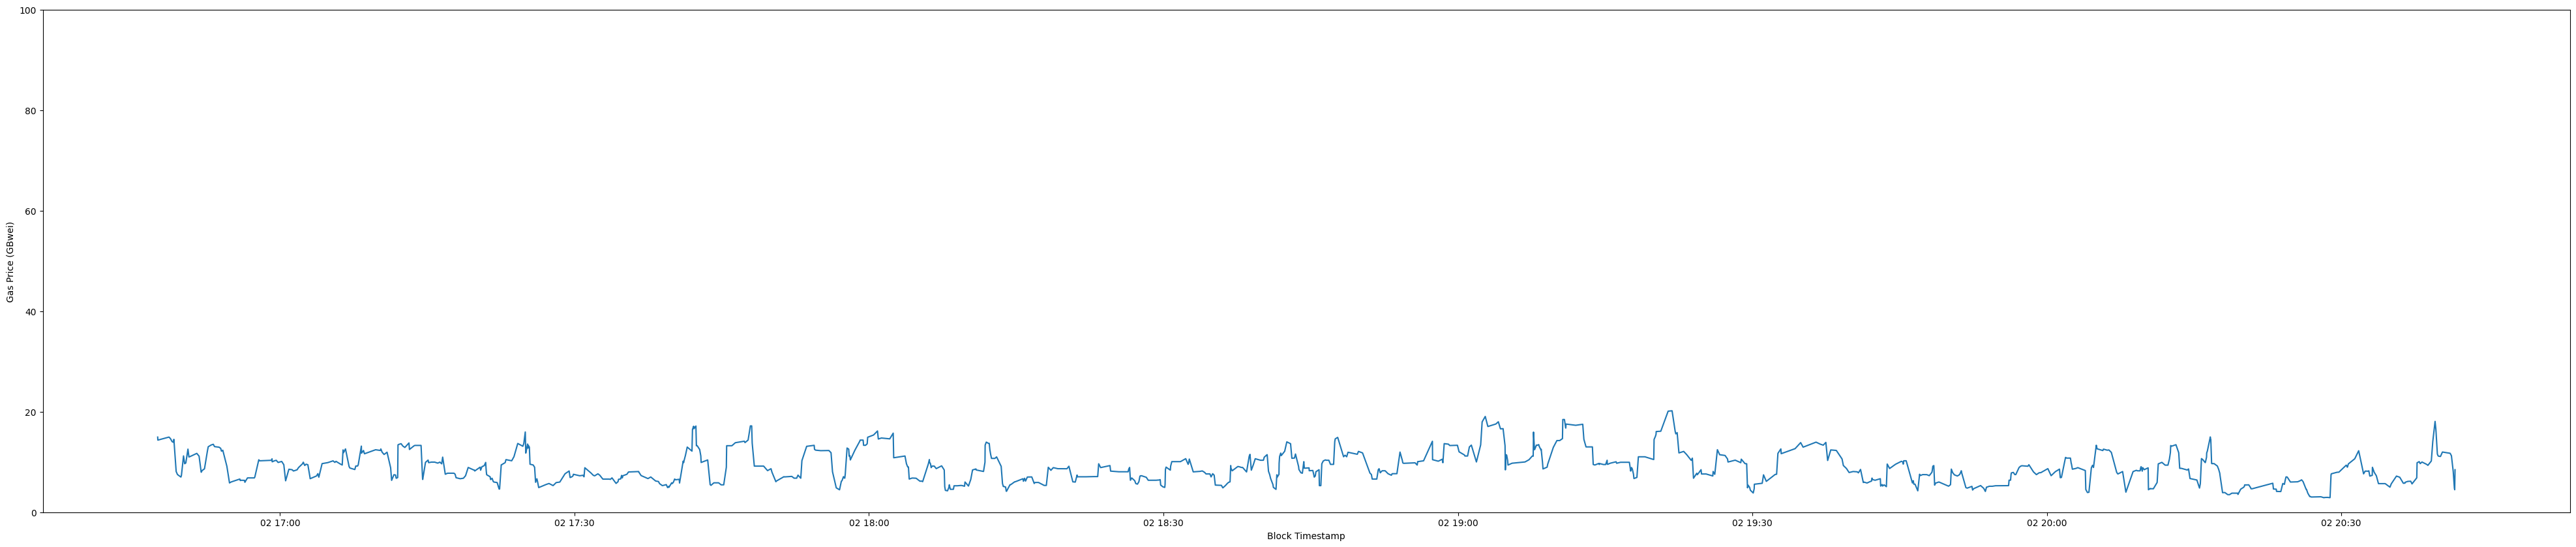

In [24]:
# set figure size
window_size = 2
median_gas_price_per_block_small["smoothed_gas_price"] = median_gas_price_per_block_small["gas_price_norm"].rolling(window=window_size).mean()
plt.figure(figsize=(50, 10))
plt.plot(median_gas_price_per_block_small['block_timestamp'], median_gas_price_per_block_small['smoothed_gas_price'])
plt.ylim(0, 100)
plt.xlabel('Block Timestamp')
plt.ylabel('Gas Price (GBwei)')

In [ ]:
df

In [2]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
print(dataset)

: 

In [3]:
# sort by block_timestamp and then by transaction_index
df = df.sort_values(by=['block_timestamp', 'transaction_index'])
# reset index
df = df.reset_index(drop=True)
df

,block_timestamp,transaction_index,receipt_effective_gas_price
0,2017-01-01 00:00:31 UTC,0,40000000000
1,2017-01-01 00:00:31 UTC,1,20000000000
2,2017-01-01 00:00:31 UTC,2,20000000000
3,2017-01-01 00:00:31 UTC,3,20000000000
4,2017-01-01 00:00:31 UTC,4,20000000000
...,...,...,...
355079945,2019-01-02 20:41:33 UTC,72,1030000000
355079946,2019-01-02 20:41:33 UTC,73,1030000000
355079947,2019-01-02 20:41:33 UTC,74,1030000000
355079948,2019-01-02 20:41:33 UTC,75,1030000000


In [9]:
# Gas price in billion wei
df['gas_price_norm'] = df['receipt_effective_gas_price'] / 1e9

In [11]:
print("Min gas price: ", df['gas_price_norm'].min())
print("Max gas price: ", df['gas_price_norm'].max())

# sort by gas price
df = df.sort_values(by=['gas_price_norm'])
# reset index
df = df.reset_index(drop=True)
df
# show the top 1000 gas prices
df['gas_price_norm'].head(1000)

Min gas price:  0.0
Max gas price:  11909523.809523808


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: gas_price_norm, Length: 1000, dtype: float64

In [12]:
df['gas_price_norm'].tail(1000)

355078950    3.302290e+04
355078951    3.302697e+04
355078952    3.310000e+04
355078953    3.312100e+04
355078954    3.319006e+04
                 ...     
355079945    5.007602e+06
355079946    5.861181e+06
355079947    1.000000e+07
355079948    1.000000e+07
355079949    1.190952e+07
Name: gas_price_norm, Length: 1000, dtype: float64

KeyboardInterrupt: 

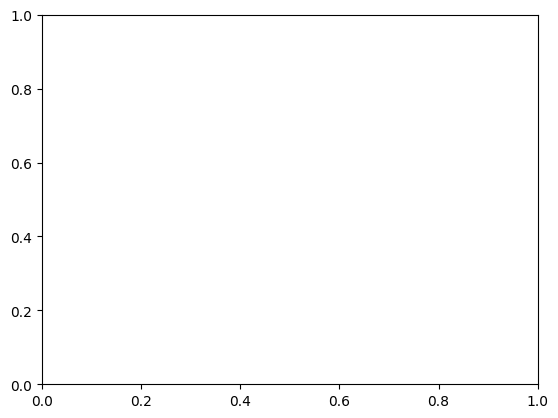

In [8]:
plt.plot(df['block_timestamp'], df['receipt_effective_gas_price'])